# Markov Decision Process (MDP)

### Ransalu Senanayake

In [49]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

Create the following grid world.

**States:** A 10x10 grid

**Actions:** Up, Down, Left, Right

**Tranistion probabilities:**
* 0.7 in the direction of action
* 0.1 in the three other directions
* The robot bounces back to the same state near edges

**Rewards:**
* (7,8) has a reward +10
* (2,7) has a reward +3
* (4,3) has a reward -5
* (7,3) has a reward -10
* No reward in other states

This example is based on Decision Making Under Uncertainty by M.J. Kochenderfer.

In [50]:
#Let's define MDP paras
def createGrid10World():
    def xy2s(y, x):
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x,y]), (10,10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10,10))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        pl.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        pl.colorbar()
        ax.set_xticks(np.arange(0, 10, 1));
        ax.set_yticks(np.arange(0, 10, 1));
        ax.set_xticklabels(np.arange(0, 10, 1));
        ax.set_yticklabels(np.arange(0, 10, 1));
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True);
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        pl.title(title);
        return

    A = ['left', 'right', 'up', 'down']
    S = np.arange(100)
    T = np.zeros((len(S), len(A), len(S)))
    R = np.zeros((len(S), len(A)))
    for s in S:
        x, y = s2xy(s)
        if x == 2 and y == 7:
            R[s, :] = 3
        elif x == 7 and y == 8:
            R[s, :] = 10
        else:
            if x == 7 and y == 3:
                R[s, :] = -10
            elif x == 4 and y == 3:
                R[s, :] = -5
            elif x == 0:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 2] = -0.7

            for a in A:
                if a == 'left':
                    T[s, 0, xy2s(x - 1, y)] += 0.7
                    T[s, 0, xy2s(x + 1, y)] += 0.1
                    T[s, 0, xy2s(x, y - 1)] += 0.1
                    T[s, 0, xy2s(x, y + 1)] += 0.1
                elif a == 'right':
                    T[s, 1, xy2s(x + 1, y)] += 0.7
                    T[s, 1, xy2s(x - 1, y)] += 0.1
                    T[s, 1, xy2s(x, y - 1)] += 0.1
                    T[s, 1, xy2s(x, y + 1)] += 0.1
                elif a == 'up':
                    T[s, 2, xy2s(x, y + 1)] += 0.7
                    T[s, 2, xy2s(x, y - 1)] += 0.1
                    T[s, 2, xy2s(x - 1, y)] += 0.1
                    T[s, 2, xy2s(x + 1, y)] += 0.1
                elif a == 'down':
                    T[s, 3, xy2s(x, y - 1)] += 0.7
                    T[s, 3, xy2s(x, y + 1)] += 0.1
                    T[s, 3, xy2s(x - 1, y)] += 0.1
                    T[s, 3, xy2s(x + 1, y)] += 0.1

    for a, c_x, c_y in [(0,0,0), (0,0,9),(1,9,0),(1,9,9),(2,0,9),(2,9,9),(3,0,0),(3,9,0)]:
        R[xy2s(c_x,c_y),a] = -0.8

    discount = 0.9

    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si,ai)] = np.where((T[si, ai, :] != 0) == True)[0]

    return {'S':S, 'A':A, 'T':T, 'R':R, 'discount':discount, 'nextStates':nextStates, 'gridPlot':gridPlot, 'xy2s':xy2s, 's2xy':s2xy}

In [51]:
class MDP():
    def __init__(self):
        pass

    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.discount = mdp_dict['discount']
        self.nextStates = mdp_dict['nextStates']
        self.gridPlot = mdp_dict['gridPlot']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']

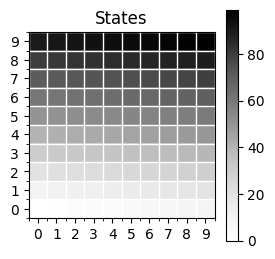

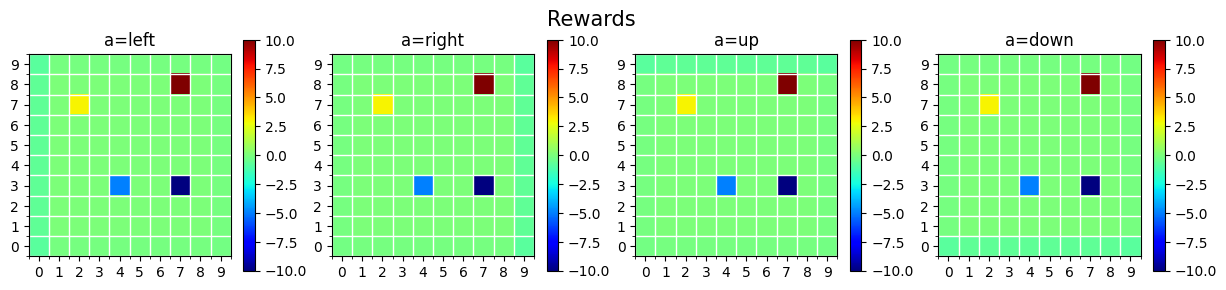

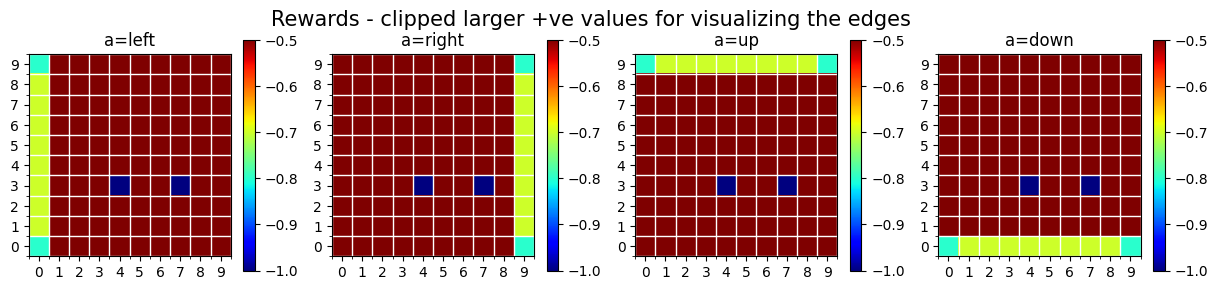

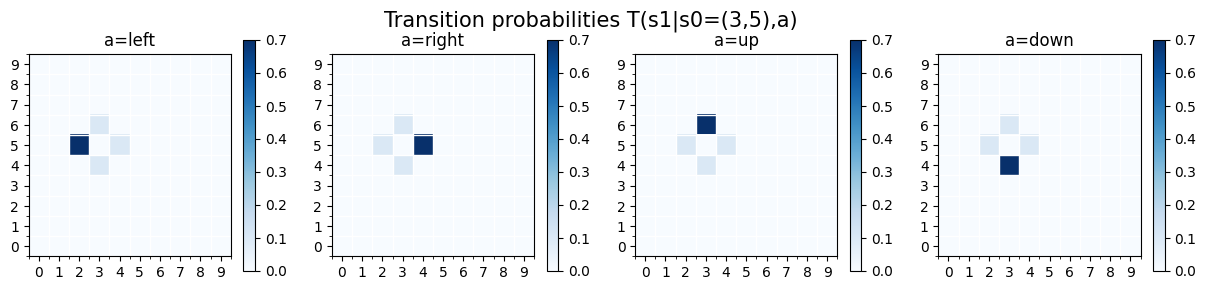

In [52]:
#Define the MDP
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

#Plot states
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=mdp.S.reshape((10,10)), title='States', cmap='Greys')

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.R[:,a].reshape((10,10)), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards - clipped larger +ve values for visualizing the edges', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=np.clip(mdp.R[:,a].reshape((10,10)), -1, -0.5), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
s0_x, s0_y = 3, 5
s0 = mdp.xy2s(s0_x, s0_y)
pl.figure(figsize=(15,3))
pl.suptitle('Transition probabilities T(s1|s0=({},{}),a)'.format(s0_x, s0_y), fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title='a='+mdp.A[a], cmap='Blues')
pl.show()

In [53]:
#An interactive plot of transition probabilities
def f(s0_x, s0_y, action):
    a = mdp.A.index(action)
    s0 = mdp.xy2s(int(s0_x), int(s0_y))
    pl.figure(figsize=(6,6))
    title = 'Transition probabilities T(s1|s0=({},{}),a={})'.format(int(s0_x),int(s0_y),action)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title=title, cmap='Blues')
    pl.show()

interactive_plot = interactive(f, s0_x='4', s0_y='5', action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']))
interactive_plot

interactive(children=(Text(value='4', description='s0_x'), Text(value='5', description='s0_y'), ToggleButtons(…

### 1. Policy evaluation

Computing the utility, U.

$U^\pi_k(s) = R(s, \pi(s)) + \gamma \sum_{s'} T(s' \mid s, \pi(s))U^\pi_{k-1}(s')$

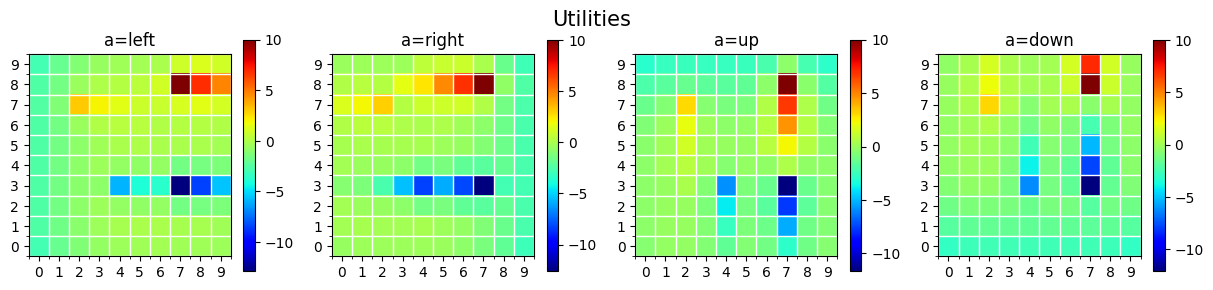

In [54]:
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
        U_old = copy.copy(U)
        for s in mdp.S:
            # For fixed policy, compute expected utility
            a = policy if isinstance(policy, int) else int(policy[s])
            U[s] = mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, :] * U_old)
    return U

numIterations = 5
pl.figure(figsize=(15,3))
pl.suptitle('Utilities', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    U = iterativePolicyEvaluation(mdp=mdp, policy=a, numIterations=numIterations)
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='a='+mdp.A[a], cmap='jet')
pl.show()
#print(np.round(U.reshape(10,10),3))

In [55]:
def f(action, numIter=1):
    U = iterativePolicyEvaluation(mdp, policy=mdp.A.index(action), numIterations=numIter)
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    pl.show()

interactive_plot = interactive(f, action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']),
                               numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(ToggleButtons(description='action', options=('left', 'right', 'up', 'down'), value='left…

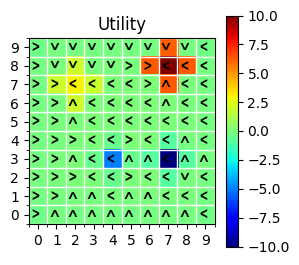

In [56]:
#Value iteration
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
        U_old = copy.copy(U)
        for s in mdp.S:
            # Bellman update: max over actions
            max_val = -np.inf
            for a in range(len(mdp.A)):
                val = mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, :] * U_old)
                max_val = max(max_val, val)
            U[s] = max_val
    return U

def policyExtration(mdp, U):
    policy = np.zeros(len(mdp.S))
    for s in mdp.S:
        best_action = 0
        best_value = -np.inf
        for a in range(len(mdp.A)):
            val = mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, :] * U)
            if val > best_value:
                best_value = val
                best_action = a
        policy[s] = best_action
    return policy

U = valueIteration(mdp, numIterations=2)
policy = policyExtration(mdp, U=U)
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
for s in range(100):
    x, y = mdp.s2xy(s)
    if policy[s] == 0:
        m='\u02C2'
    elif policy[s] == 1:
        m='\u02C3'
    elif policy[s] == 2:
        m='\u02C4'
    elif policy[s] == 3:
        m='\u02C5'
    pl.text(x-0.5,y-1,m,color='k',size=20)
pl.show()

In [57]:
def f(numIter=1):
    start_time = timeit.default_timer()
    U = valueIteration(mdp, numIterations=numIter)
    policy = policyExtration(mdp, U=U)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

### 2. Policy iteration

Policy evaluation can be used in policy iteration:
1. Given the current policy, compute U
2. Using U, compute a new policy

In [58]:
def policyIteration(mdp, numIterations=1):
    U_pi_k = np.zeros(len(mdp.S))
    pi_k = np.random.randint(low=0, high=4, size=len(mdp.S), dtype=int)
    pi_kp1 = copy.copy(pi_k)

    for t in range(numIterations):
        # Policy evaluation: compute U_pi_k (run until convergence or fixed iterations)
        U_pi_k = iterativePolicyEvaluation(mdp, pi_k, numIterations=50)

        # Policy improvement
        pi_kp1 = policyExtration(mdp, U_pi_k)

        # Check if policy has converged
        if np.array_equal(pi_k, pi_kp1):
            break
        pi_k = copy.copy(pi_kp1)

    return U_pi_k, pi_kp1


U_pi_k, pi_kp1 = policyIteration(mdp, numIterations=2)

In [59]:
def f(numIter=1):
    start_time = timeit.default_timer()
    # code you want to evaluate
    value, policy = policyIteration(mdp, numIterations=numIter)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

In [65]:


def qLearning(mdp, numEpisodes=1000, maxStepsPerEpisode=100, alpha=0.1, epsilon=0.1):
    """
    Q-Learning algorithm (Model-Free approach)
    """
    Q = np.zeros((len(mdp.S), len(mdp.A)))

    for episode in range(numEpisodes):
        # Start from random state
        s = np.random.choice(mdp.S)

        for step in range(maxStepsPerEpisode):
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                a = np.random.choice(len(mdp.A))  # Explore
            else:
                a = np.argmax(Q[s, :])  # Exploit

            # Sample next state from transition probabilities
            next_state_probs = mdp.T[s, a, :]
            valid_states = np.where(next_state_probs > 0)[0]

            if len(valid_states) == 0:
                s_next = s
            else:
                probs = next_state_probs[valid_states]
                probs = probs / probs.sum()
                s_next = np.random.choice(valid_states, p=probs)

            # Get reward
            r = mdp.R[s, a]

            # Q-Learning update
            Q[s, a] = Q[s, a] + alpha * (r + mdp.discount * np.max(Q[s_next, :]) - Q[s, a])

            s = s_next

    # Extract policy and value function
    policy = np.argmax(Q, axis=1)
    U = np.max(Q, axis=1)

    return U, policy, Q

def compare_algorithms(mdp, iterations_list=[1, 5, 10, 15, 20]):
    """
    Compare Value Iteration, Policy Iteration, and Q-Learning
    """
    results = {
        'Value Iteration': {'times': [], 'utilities': []},
        'Policy Iteration': {'times': [], 'utilities': []},
        'Q-Learning': {'times': [], 'utilities': []}
    }

    print("=" * 80)
    print("ALGORITHM COMPARISON: Model-Based vs Model-Free")
    print("=" * 80)

    for num_iter in iterations_list:
        print(f"\n{'='*80}")
        print(f"Iterations: {num_iter}")
        print(f"{'='*80}")

        # Value Iteration (Model-Based)
        start_time = timeit.default_timer()
        U_vi = valueIteration(mdp, numIterations=num_iter)
        time_vi = (timeit.default_timer() - start_time) * 1000
        results['Value Iteration']['times'].append(time_vi)
        results['Value Iteration']['utilities'].append(U_vi)
        print(f"Value Iteration:   Time = {time_vi:.3f} ms, Max Utility = {np.max(U_vi):.3f}")

        # Policy Iteration (Model-Based)
        start_time = timeit.default_timer()
        U_pi, policy_pi = policyIteration(mdp, numIterations=num_iter)
        time_pi = (timeit.default_timer() - start_time) * 1000
        results['Policy Iteration']['times'].append(time_pi)
        results['Policy Iteration']['utilities'].append(U_pi)
        print(f"Policy Iteration:  Time = {time_pi:.3f} ms, Max Utility = {np.max(U_pi):.3f}")

        # Q-Learning (Model-Free) - scale episodes with iterations
        episodes = num_iter * 100
        start_time = timeit.default_timer()
        U_ql, policy_ql, Q = qLearning(mdp, numEpisodes=episodes, alpha=0.1, epsilon=0.1)
        time_ql = (timeit.default_timer() - start_time) * 1000
        results['Q-Learning']['times'].append(time_ql)
        results['Q-Learning']['utilities'].append(U_ql)
        print(f"Q-Learning:        Time = {time_ql:.3f} ms, Max Utility = {np.max(U_ql):.3f} (Episodes: {episodes})")

    return results

# NOW RUN THE COMPARISON - This creates the 'results' variable
results = compare_algorithms(mdp, iterations_list=[1, 5, 10, 15, 20])

ALGORITHM COMPARISON: Model-Based vs Model-Free

Iterations: 1
Value Iteration:   Time = 3.975 ms, Max Utility = 10.000
Policy Iteration:  Time = 51.648 ms, Max Utility = 10.000
Q-Learning:        Time = 397.264 ms, Max Utility = 99.917 (Episodes: 100)

Iterations: 5
Value Iteration:   Time = 19.115 ms, Max Utility = 10.000
Policy Iteration:  Time = 266.492 ms, Max Utility = 10.000
Q-Learning:        Time = 1626.822 ms, Max Utility = 100.000 (Episodes: 500)

Iterations: 10
Value Iteration:   Time = 36.506 ms, Max Utility = 10.000
Policy Iteration:  Time = 217.981 ms, Max Utility = 10.000
Q-Learning:        Time = 1945.177 ms, Max Utility = 100.000 (Episodes: 1000)

Iterations: 15
Value Iteration:   Time = 33.762 ms, Max Utility = 10.000
Policy Iteration:  Time = 211.677 ms, Max Utility = 10.000
Q-Learning:        Time = 2885.229 ms, Max Utility = 100.000 (Episodes: 1500)

Iterations: 20
Value Iteration:   Time = 43.645 ms, Max Utility = 10.000
Policy Iteration:  Time = 210.894 ms, Max 

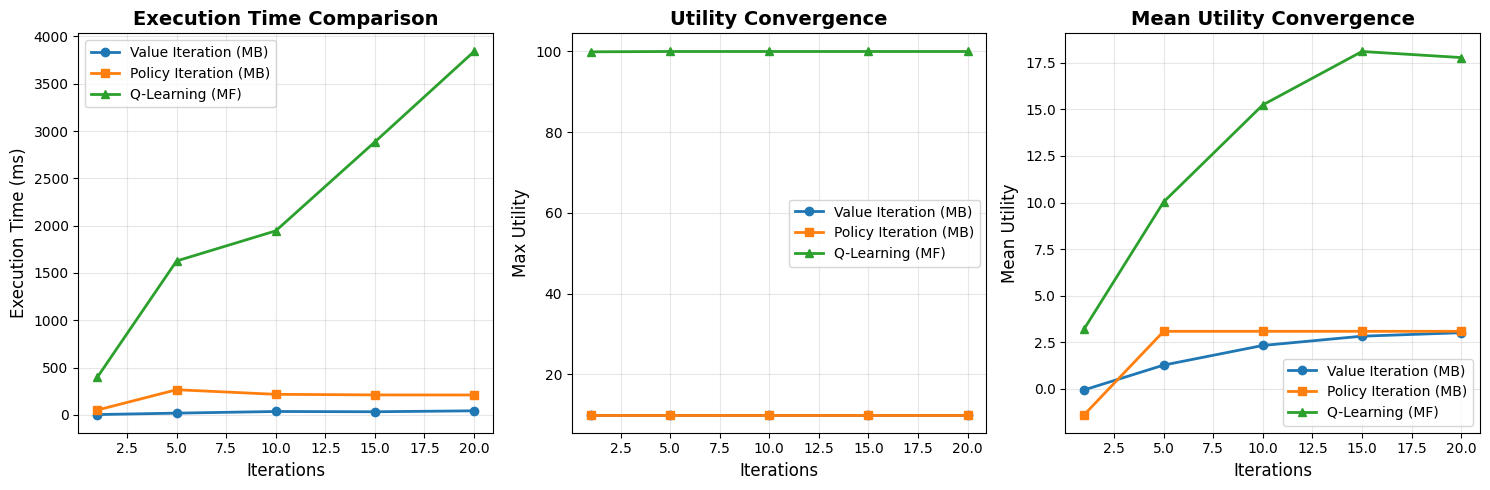

In [66]:
# Plot convergence comparison
pl.figure(figsize=(15, 5))

# Plot 1: Execution Time
pl.subplot(1, 3, 1)
iterations_list = [1, 5, 10, 15, 20]
pl.plot(iterations_list, results['Value Iteration']['times'], 'o-', label='Value Iteration (MB)', linewidth=2)
pl.plot(iterations_list, results['Policy Iteration']['times'], 's-', label='Policy Iteration (MB)', linewidth=2)
pl.plot(iterations_list, results['Q-Learning']['times'], '^-', label='Q-Learning (MF)', linewidth=2)
pl.xlabel('Iterations', fontsize=12)
pl.ylabel('Execution Time (ms)', fontsize=12)
pl.title('Execution Time Comparison', fontsize=14, fontweight='bold')
pl.legend()
pl.grid(True, alpha=0.3)

# Plot 2: Max Utility Convergence
pl.subplot(1, 3, 2)
max_utils_vi = [np.max(u) for u in results['Value Iteration']['utilities']]
max_utils_pi = [np.max(u) for u in results['Policy Iteration']['utilities']]
max_utils_ql = [np.max(u) for u in results['Q-Learning']['utilities']]

pl.plot(iterations_list, max_utils_vi, 'o-', label='Value Iteration (MB)', linewidth=2)
pl.plot(iterations_list, max_utils_pi, 's-', label='Policy Iteration (MB)', linewidth=2)
pl.plot(iterations_list, max_utils_ql, '^-', label='Q-Learning (MF)', linewidth=2)
pl.xlabel('Iterations', fontsize=12)
pl.ylabel('Max Utility', fontsize=12)
pl.title('Utility Convergence', fontsize=14, fontweight='bold')
pl.legend()
pl.grid(True, alpha=0.3)

# Plot 3: Mean Utility Convergence
pl.subplot(1, 3, 3)
mean_utils_vi = [np.mean(u) for u in results['Value Iteration']['utilities']]
mean_utils_pi = [np.mean(u) for u in results['Policy Iteration']['utilities']]
mean_utils_ql = [np.mean(u) for u in results['Q-Learning']['utilities']]

pl.plot(iterations_list, mean_utils_vi, 'o-', label='Value Iteration (MB)', linewidth=2)
pl.plot(iterations_list, mean_utils_pi, 's-', label='Policy Iteration (MB)', linewidth=2)
pl.plot(iterations_list, mean_utils_ql, '^-', label='Q-Learning (MF)', linewidth=2)
pl.xlabel('Iterations', fontsize=12)
pl.ylabel('Mean Utility', fontsize=12)
pl.title('Mean Utility Convergence', fontsize=14, fontweight='bold')
pl.legend()
pl.grid(True, alpha=0.3)

pl.tight_layout()
pl.show()

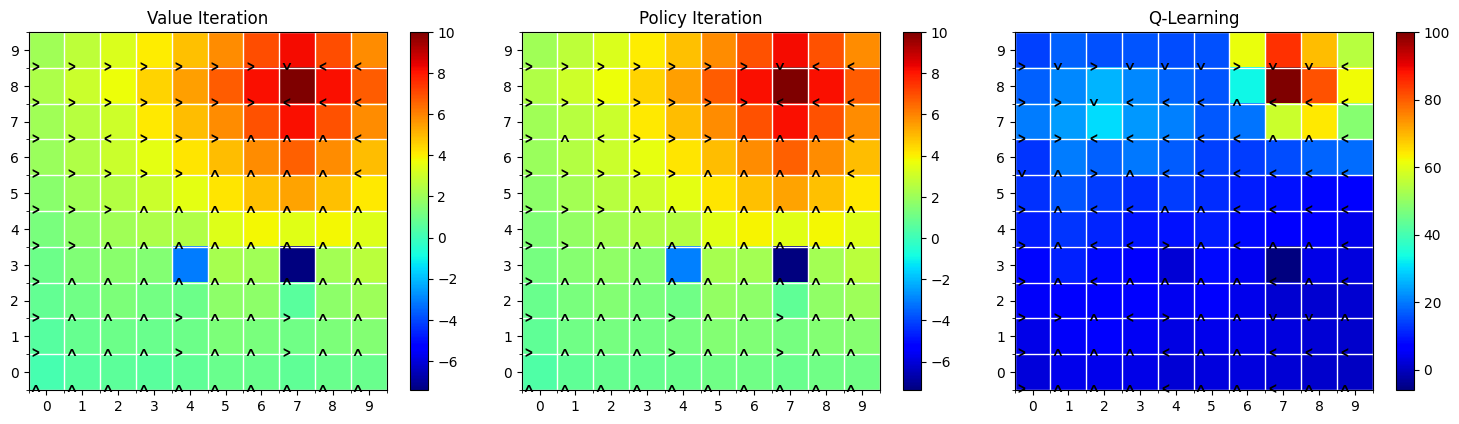

In [67]:
# Final policies visualization
pl.figure(figsize=(15, 4))
U_vi_final = valueIteration(mdp, numIterations=20)
U_pi_final, policy_pi_final = policyIteration(mdp, numIterations=20)
U_ql_final, policy_ql_final, _ = qLearning(mdp, numEpisodes=2000, alpha=0.1, epsilon=0.1)

for idx, (U, policy, title) in enumerate([
    (U_vi_final, policyExtration(mdp, U_vi_final), 'Value Iteration'),
    (U_pi_final, policy_pi_final, 'Policy Iteration'),
    (U_ql_final, policy_ql_final, 'Q-Learning')
]):
    pl.subplot(1, 3, idx + 1)
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10, 10), title=title, cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m = '\u02C2'
        elif policy[s] == 1:
            m = '\u02C3'
        elif policy[s] == 2:
            m = '\u02C4'
        elif policy[s] == 3:
            m = '\u02C5'
        pl.text(x - 0.5, y - 1, m, color='k', size=20)

pl.tight_layout()
pl.show()

## Model-Based algorithms:

- Learn or use a model of the environment (i.e., the transition probabilities and rewards).

- Can plan ahead by simulating future states and choosing actions accordingly.

- Example: Value Iteration, Policy Iteration.

- Pros: Often sample-efficient; can adapt quickly if the model is accurate.

- Cons: Requires knowledge or learning of the model, which can be complex in large environments.

## Model-Free algorithms:

- Learn directly from experience (interactions with the environment) without explicitly modeling it.

- Estimate the value of actions or policies from observed rewards.

- Example: Q-Learning, SARSA, REINFORCE.

- Pros: Simpler; works even when the environment model is unknown.

- Cons: Often requires more data (less sample-efficient); may converge slower.

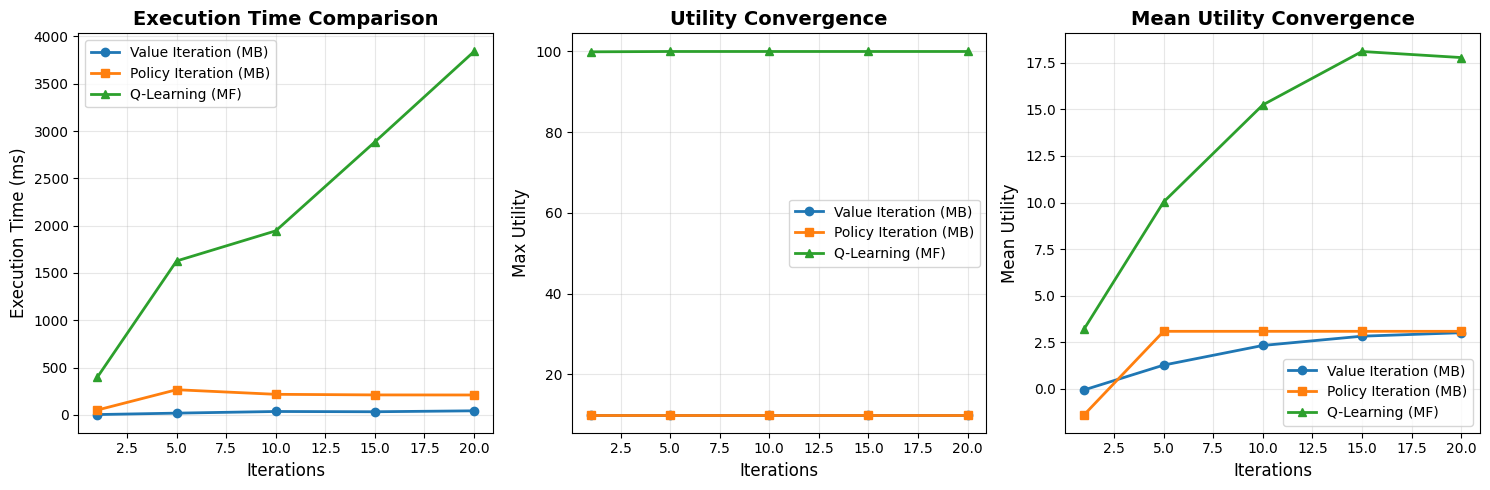
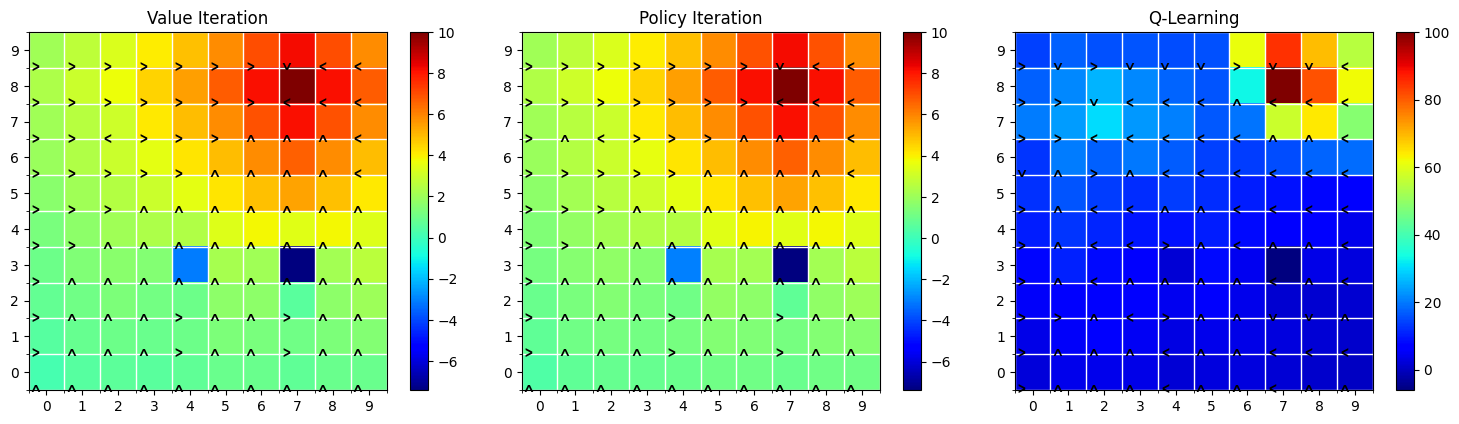